# Методы машинного обучения

## Семинар 7. Модель линейной классификации. Логистическая регрессия

## Проверочная работа

- Как выглядит модель линейной регрессии с d признаками? Напишите модель (зависимость $a(w, X)$) и опишите свои обозначения.
- Запишите формулу MSE (среднеквадратичной ошибки) для линейной регрессии и опишите обозначения.
- Что такое гиперпараметр? Почему гиперпараметры нельзя подбирать по обучающей выборке? Приведите пример гиперпараметра в любой известной вам модели.
- Представьте, что вы оптимизируете функцию $f(w)$ с помощью градиентного спуска. Как выглядит шаг спуска? Запишите формулу и поясните обозначения.

Для работы нам понадобятся некоторые библиотеки: 
* `pandas` — библиотека для удобной работы с таблицами;
* `NumPy` — библиотека для работы с массивами;
* `scikit-learn` — библиотека, которая содержит реализации множества алгоритмов машинного обучения;
* `matplotlib` — библиотека для построения графиков.

In [6]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.datasets import make_classification
from sklearn.datasets import make_regression
from sklearn.datasets import make_moons

from sklearn.model_selection import train_test_split

from sklearn import metrics

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from mlxtend.plotting import plot_decision_regions

%config InlineBackend.figure_format='retina'
%matplotlib inline

## План

- Вспомним, как устроены линейные модели классификации и основные связанные с ними понятия
- Применим логистическую (и линейную) регрессию на небольшом реальном датасете
- Научимся выделять линейным классификатором нелинейную закономерность

## Вспомним моменты из лекции

### Отличие задачи классификации от задачи регрессии:

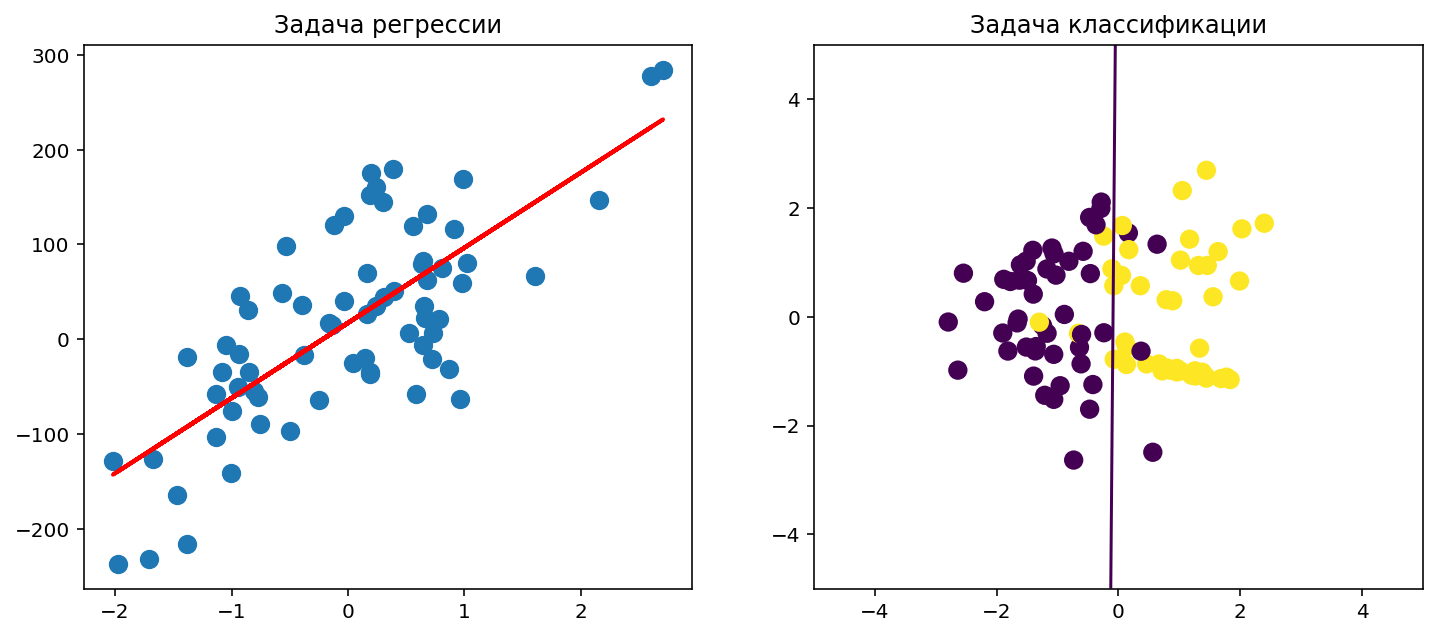

In [7]:
np.random.seed(101)

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.title("Задача регрессии")
X1, Y1 = make_regression(n_samples=70, n_features=2, noise=1.)
plt.scatter(X1[:, 0], Y1, marker='o', s=75)

model_reg = LinearRegression().fit(X1[:, 0].reshape(-1, 1), Y1)
y_pred = model_reg.predict(X1[:, 0].reshape(-1, 1))
plt.plot(X1[:, 0], y_pred, color='red', linewidth=2)

plt.subplot(122)
plt.title("Задача классификации")
X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=2)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1, s=75)

model_clf = LogisticRegression(solver='lbfgs').fit(X1, Y1)
xx = np.linspace(-5, 5, 2)
yy = np.linspace(-5, 5, 2)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model_clf.decision_function(xy).reshape(XX.shape)
plt.gca().contour(XX, YY, Z, levels=[0])

plt.show()

Решение задачи регрессии — это алгоритм, которые дает вещественные предсказания, наиболее соответствующие предполагаемому типу зависимости в исходных данных. 

Решение задачи классификации — алгоритм, который предсказывает *класс* (то есть метку) объекта. Бинарная классификация — работаем с двумя классами. Из лекции:

- $\mathbb{Y} = \{-1, +1\}$ множество возможных классов
- $-1$ — «отрицательный» класс
- $+1$ — «положительный» класс
- $a(x)$ — алгоритм, который для объекта $x$ возвращает одно из этих чисел.

<h3>Примеры задач, которые решаются при помощи классификации:</h3>
<ul>
<li> Кредитный скоринг
<li> Фильтрация спама
<li> Оценка принадлежности страны равитым или развивающимся странам
<li> Медицинская диагностика
<li> Определение вида объекта на картинке
<li> Предсказание погоды
<li> И многое другое
</ul>

**Почему для классификации нельзя использовать обычную линейную регрессию?**

### Бинарный линейный классификатор

$a(x) = \text{sign}\left(\sum\limits_{j=1}^{d + 1} w_j x_j \right) = \text{sign}\langle w, x \rangle$

По сути — подбираем гиперплоскость ($\langle w, x \rangle = 0$), и все объекты по одну сторону относим к одному классу, а по другую — к другому. Как измерить ошибку?

Хотели бы минимизировать долю ошибок:

$Q(a, X) = \dfrac{1}{l} \sum\limits_{i=1}^l \left[ y_i a(x_i) < 0 \right] = \dfrac{1}{l} \sum\limits_{i=1}^l \left[ y_i \langle w, x_i \rangle < 0 \right] $

— но напрямую так делать не можем (например, градиентный спуск не подойдет, потому что функция разрывна). Поэтому минимизируем **какую-то** гладкую верхнюю оценку $L$:

$Q(a, X) \le L(a, X) \to \min\limits_w$

и надеемся, что доля ошибок тоже уменьшится.

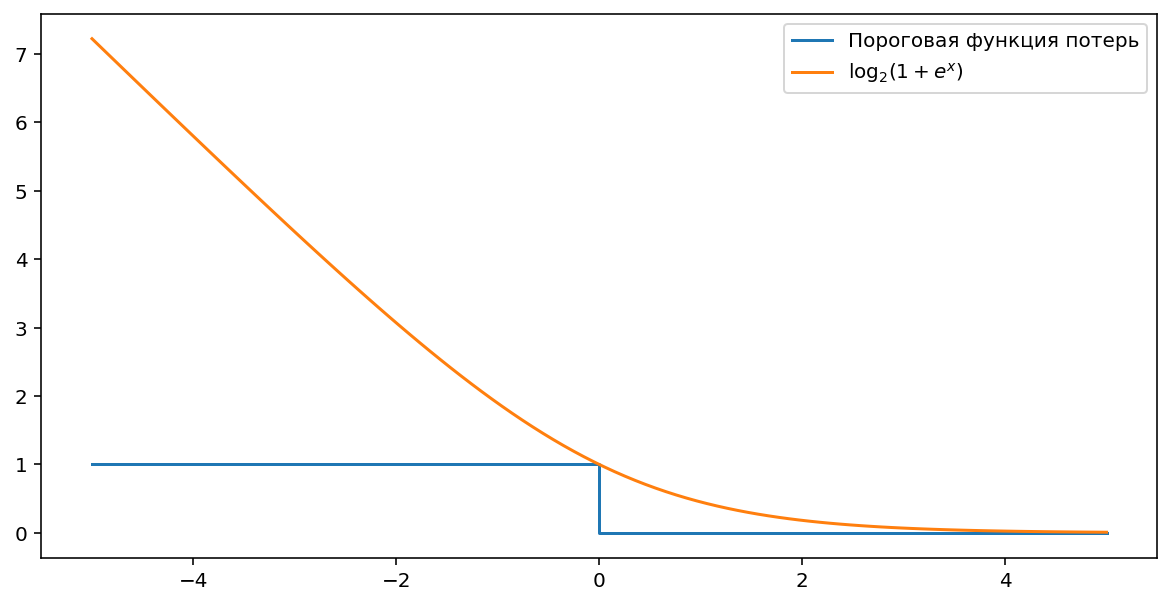

In [8]:
def logistic(x):
    return np.log2(1 + np.exp(-x))

plt.figure(figsize=(10, 5))
plt.plot([-5, 0, 0, 5], [1, 1, 0, 0], label='Пороговая функция потерь')

xx = np.linspace(-5, 5, 100)
plt.plot(xx, logistic(xx), label='$\log_2(1 + e^x)$')

plt.legend()
plt.show()

(Показать график с минимизацией)

Отступ для объекта $x_i$ — значение $M_i$ = $y_i\langle w, x_i \rangle$.

- $M_i > 0$ — классификатор дал верный ответ
- $M_i < 0$ — классификатор ошибся
- Чем дальше от нуля, тем больше «уверенности»

Разберемся на простейшем двумерном случае:

In [43]:
def compute_margin(x_coord, y_coord, w_x, w_y, w_0, y_true):
    pass

def threshold_loss(x_coord, y_coord, w_x, w_y, w_0, y_true):
    # пороговая функция потерь для одной точки
    pass

def logistic_loss(x_coord, y_coord, w_x, w_y, w_0, y_true):
    # логистическая верхняя оценка
    pass

In [44]:
def weights_to_ab(w_x, w_y, w_0):
    return -w_x / w_y, -w_0 / w_y

def margin_xy_from_margin_and_slope(margin, slope):
    return margin * np.sin(np.arctan(slope)), margin * np.cos(np.arctan(slope))

In [88]:
def visualize_margin(idx_seed=2, data_seed=50):
    plt.figure(figsize=(8, 5))
    plt.title("Задача классификации")

    X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=2, random_state=data_seed)
    plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1, s=75)
    model_clf = LogisticRegression(solver='lbfgs').fit(X1, Y1)
    xx = np.linspace(-5, 5, 2)
    yy = np.linspace(-5, 5, 2)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model_clf.decision_function(xy).reshape(XX.shape)
    plt.gca().contour(XX, YY, Z, levels=[0])

    np.random.seed(idx_seed)
    random_idx = np.random.randint(len(X1))
    x, y = X1[random_idx]
    plt.scatter([x], [y], s=200, facecolors='none', edgecolors='r', linestyle='--')

    # напечатайте значение отступа, пороговой функции потерь и верхней оценки
    

    plt.show()

2.650065675432034 2.650065675432034
0.35927943668167905 -0.1471077886502671


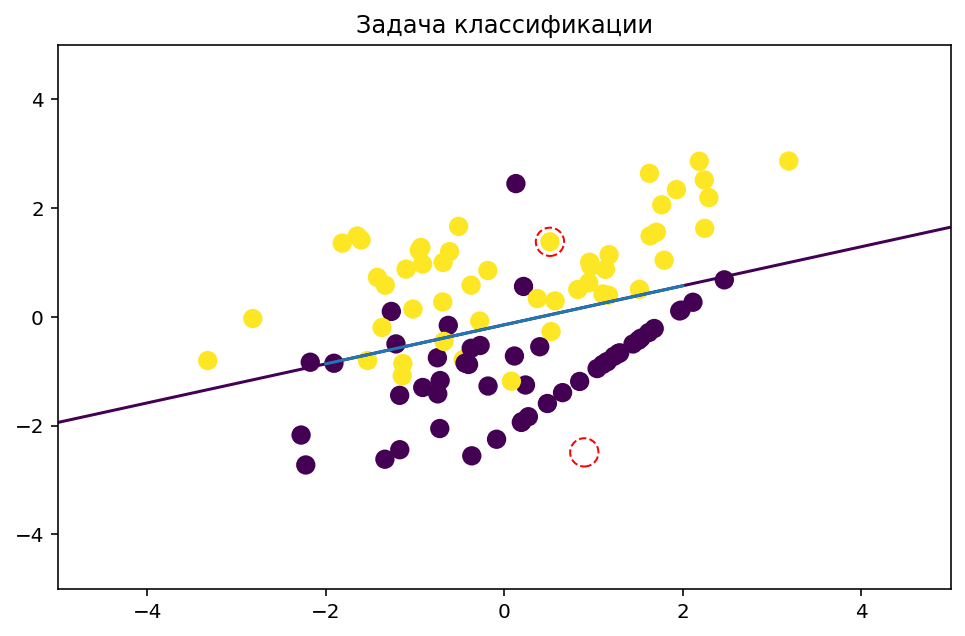

In [89]:
visualize_margin(5)

### Данные для задачи классификации:

Рассмотрим пример задачи классификации на примере очень популярного датасета: https://www.kaggle.com/c/titanic. Мы хотим построить модель, которая бы корректно предсказывала выживаемость пассажира при крушении в зависимости от известных о нем данных.

* `PassengerId` – id пассажира (int32)
* `Survived` – выжил ли пассажир (bool) {1-да, 0-нет}
* `Name` – имя пассижира (str) 
* `Pclass` – класс каюты (int32)
* `Sex` – пол пассажира (int32)  	
* `Age` – возраст	
* `Sibsp` – кол-во братьев/систер и супргов/жен на борту (int32)
* `Parch` – кол-во родителей/детей на борту (int32)
* `Ticket` – номер билета (int32)
* `Fare` – стоимость билета (float32)
* `Cabin` – номер каюты (str)	
* `Embarked` – порт посадки (str) {C - Cherbourg, S - Southampton, Q - Queenstown}

In [ ]:
url = 'http://gg.gg/mirec_dataset'
df = pd.read_csv(url, index_col=['PassengerId'])

Посмотрим на начало таблицы:

In [57]:
df.head()
# code

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Есть ли в данных пропуски?

In [58]:
df.isnull().any()
# code

Survived    False
Pclass      False
Name        False
Sex         False
Age          True
SibSp       False
Parch       False
Ticket      False
Fare        False
Cabin        True
Embarked     True
dtype: bool

Давайте заполним пропуски в `Age` при помощи линейной регрессии. 

Почему сначала нужно разбить данные на `test` и `train`, а уже потом заполнять пропуски регрессией отдельно? Почему нельзя использовать целевой признак как фичу для линейной регрессии?

---

Сначала преобразуем наши данные так, чтобы на них можно было запустить линейную регрессию. Например, уберем имя, номер билета и каюты — они не числовые и вряд ли нам помогут.

In [ ]:
df = df.drop(['Name', 'Ticket', 'Cabin'], axis=1)
# your code

А вот порт посадки и пол пассажира вполне могут улучшить предсказания, но в линейной регрессии их использовать просто так не получится. Создадим из них dummy-признаки с помощью функции `get_dummies` из `pandas`.

In [ ]:
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)
# your code

In [61]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1,0,1
2,1,1,38.0,1,0,71.2833,0,0,0
3,1,3,26.0,0,0,7.9250,0,0,1
4,1,1,35.0,1,0,53.1000,0,0,1
5,0,3,35.0,0,0,8.0500,1,0,1


В таблице появились вместо этих категориальных признаков столбцы для каждого возможного значения — с нулем, если это значение не соответствует объекту, и единицей, если соответствует. **Из-за того, что мы указали аргумент `drop_first=True`, по одному значению каждого признака было удалено. Как вы думаете, почему мы так сделали?**

В данных есть еще одна небольшая проблема — хоть класс каюты и представлен числом, но там нет никакой равномерной шкалы, по сути он категориальный. Создадим дамми и для него.

In [ ]:
df = pd.get_dummies(df, columns=['Pclass'], drop_first=True)
# your code

Как и на прошлых семинарах, чтобы у нас была возможность честно проверить модели, выборку нужно разбить на `train` и `test`. На `train` мы будем обучать модели, а на `test` проверять качество работы алгоритмов.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Survived', axis=1), df['Survived'], test_size=0.3, random_state=42)
# your code (test_size 0.3, random_state 42)

Заполняем пропуски регрессией для `X_train`:

In [66]:
lr = LinearRegression()
lr.fit(X_train.dropna().drop('Age', axis=1), X_train.dropna()['Age'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# получите подмножество строк, где Age пустой
# предскажите Age, не забыв его убрать из таблицы
# найдите индексы строк, где Age пустой
# составьте словарь {индекс: предсказание}
X_train['Age'] = X_train['Age'].fillna(age_dict)

Заполняем пропуски регрессией для `X_test`:

In [ ]:
# то же самое

Наконец, мы готовы применить логистическую регрессию:

In [ ]:
# fit, predict, посчитать accuracy на train и test

Посмотреть на вероятности

## Немножко Feature Engineering

Вспомним игрушечный датасет из семинара про KNN. 

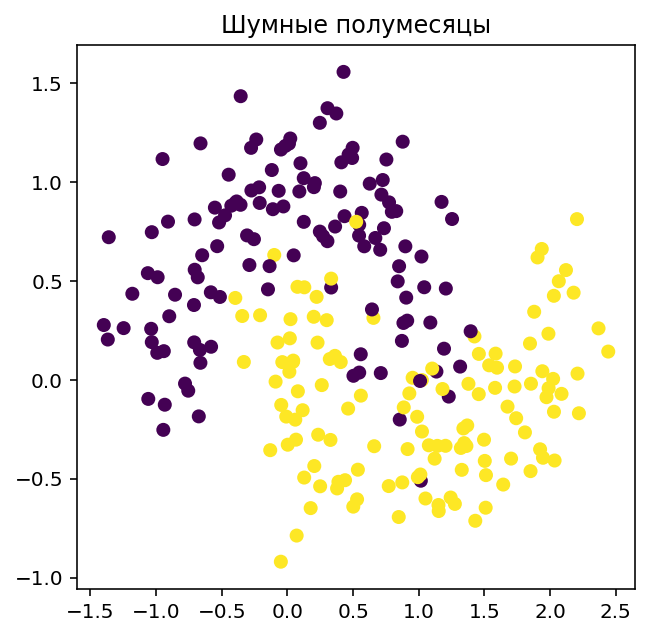

In [35]:
np.random.seed(8)

X, y = make_moons(250, noise=0.25)

plt.figure(figsize=(5, 5))
plt.title('Шумные полумесяцы')
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

Логистическая регрессия строит линейную разделяющую плоскость в пространстве признаков. Значит ли это, что мы не можем достичь лучшего на таких данных?

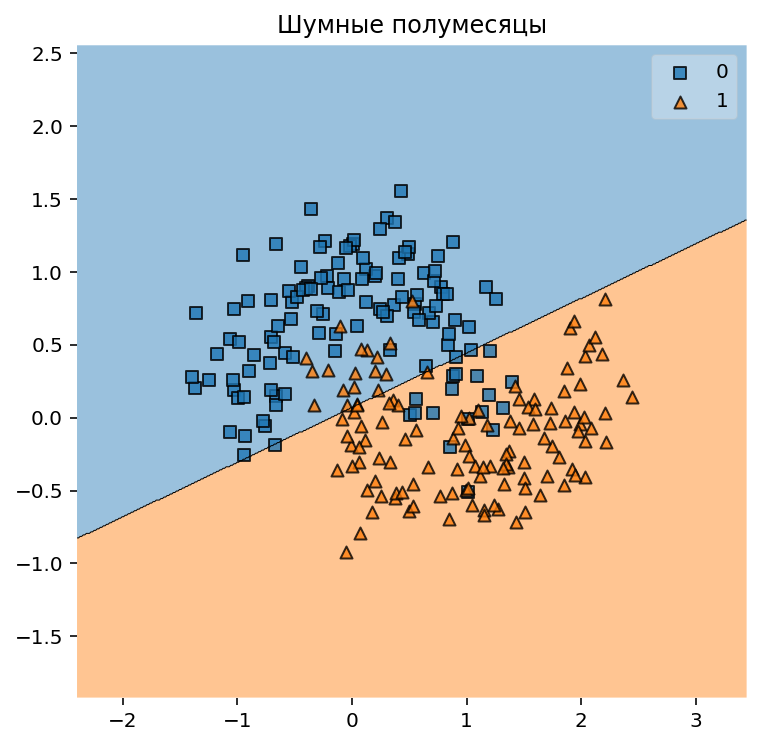

In [37]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X, y)

plt.figure(figsize=(6, 6))
plt.title('Шумные полумесяцы')

plot_decision_regions(X, y, lr)

plt.show()

In [ ]:
print(f'Accuracy (train): {# your code}')

«Правильная» разделяющая поверхность между полумесяцами напоминает кубическую параболу — сгенерируем кубические признаки!

In [ ]:
# your code: пайплайн — StandardScaler, PolynomialFeatures, LinearRegression

In [ ]:
# your code: показать decision_regions

In [33]:
print(f'Accuracy (train): {# your code}')

Accuracy (train): 0.908
